### Dimensionality Reduction

- Dimensionality reduction techniques are used to reduce the number of input variables (features) in a dataset while preserving as much information as possible. This is useful for visualization, speeding up computations, reducing noise, and avoiding the curse of dimensionality in machine learning tasks.


> In this notebook we are going to implement some dimensionality reduction techniques using `linear` and `nonlinear` methods.

We are going to start by installing the package called `umap-learn` by running the following command.

> https://umap-learn.readthedocs.io/en/latest/

In [5]:
pip install umap-learn -q

Note: you may need to restart the kernel to use updated packages.


And then we are going to import all the packages that we are going to use in this notebook as follows:

In [16]:
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import umap.umap_ as umap
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA,  FactorAnalysis, FastICA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
from tensorflow.keras import layers, models
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding, Isomap

import warnings
import torch
import random


warnings.filterwarnings("ignore")
print("tensorflow: ", tf.__version__)
print("torch: ", torch.__version__)
print("numpy: ", np.__version__)

tensorflow:  2.15.0
torch:  2.3.0
numpy:  1.26.4


### Seed
In the following code cell we are going to set the seed for random operations in this notebook for reproducivity.

In [18]:
SEED = 17
tf.random.set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Dataset.
In the following code cell we are going to load the dataset that we are going to use in this notebook, which is the `iris` dataset.

In [25]:
iris = load_iris()
X = iris.data
y = iris.target

print(X.shape)

(150, 4)


### 1. Principal Component Analysis (PCA)

- Projects data onto directions (principal components) that maximize variance.
- Assumes linear relationships.
- Common for data compression and visualization.


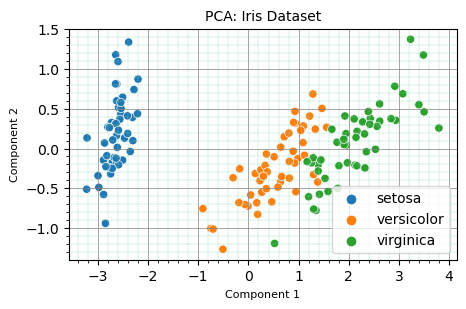

In [33]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=iris.target_names[y])
plt.title("PCA: Iris Dataset", fontsize=10)
plt.xlabel("Component 1", fontsize=8)
plt.ylabel("Component 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()

### 2. t-SNE (t-Distributed Stochastic Neighbor Embedding)
- Converts high-dimensional distances into conditional probabilities.
- Excels in visualizing clusters in 2D or 3D.
- Computationally intensive and not ideal for large datasets.

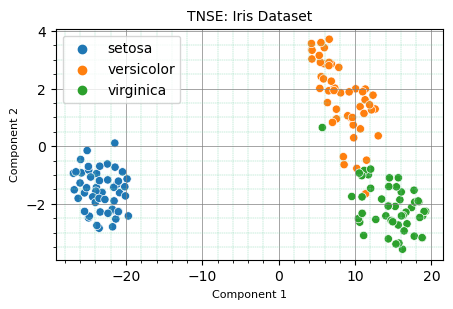

In [37]:
tsne = TSNE(n_components=2, random_state=SEED)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=iris.target_names[y])
plt.title("TNSE: Iris Dataset", fontsize=10)
plt.xlabel("Component 1", fontsize=8)
plt.ylabel("Component 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()

### 3. UMAP

- Similar to t-SNE but faster and better at preserving global structure.
- Great for visualization and downstream tasks.

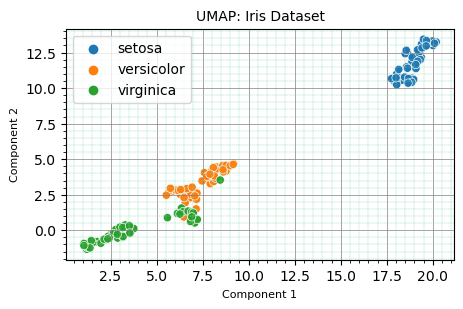

In [39]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=iris.target_names[y])
plt.title("UMAP: Iris Dataset", fontsize=10)
plt.xlabel("Component 1", fontsize=8)
plt.ylabel("Component 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()

### 4. Autoencoder (with TensorFlow/Keras)
- Learns to compress and reconstruct data using encoder-decoder architecture.
- Useful for both linear and nonlinear reductions.
- Flexible, can be deep or shallow.




5/5 [==============================] - 0s 4ms/step


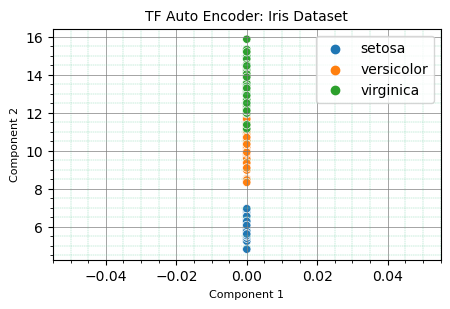

In [41]:
input_dim = X.shape[1]
encoding_dim = 2
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='linear')(encoded)
autoencoder = models.Model(input_layer, decoded)
encoder = models.Model(input_layer, encoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X, X, epochs=100, batch_size=16, verbose=0)
X_encoded = encoder.predict(X)


plt.figure(figsize=(5, 3))
sns.scatterplot(x=X_encoded[:,0], y=X_encoded[:,1], hue=iris.target_names[y])
plt.title("TF Auto Encoder: Iris Dataset", fontsize=10)
plt.xlabel("Component 1", fontsize=8)
plt.ylabel("Component 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()

The following code cell we will show how to implement the auto encoder in pytorch.

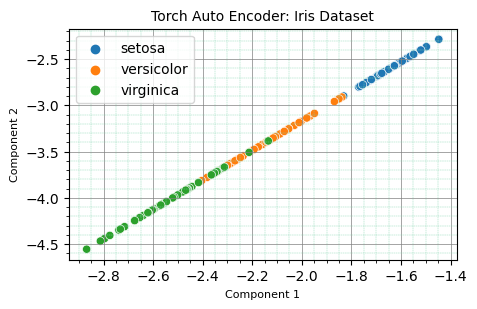

In [46]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=4, encoding_dim=2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

X_tensor = torch.tensor(X, dtype=torch.float32)

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    output, _ = model(X_tensor)
    loss = criterion(output, X_tensor)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    _, X_auto = model(X_tensor)

X_auto = X_auto.numpy()

plt.figure(figsize=(5, 3))
sns.scatterplot(x=X_auto[:,0], y=X_auto[:,1], hue=iris.target_names[y])
plt.title("Torch Auto Encoder: Iris Dataset", fontsize=10)
plt.xlabel("Component 1", fontsize=8)
plt.ylabel("Component 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()

### 5. Linear Discriminant Analysis (LDA)
- Supervised method that maximizes class separability.
- Projects data in a way that maximizes the ratio of between-class to within-class variance.


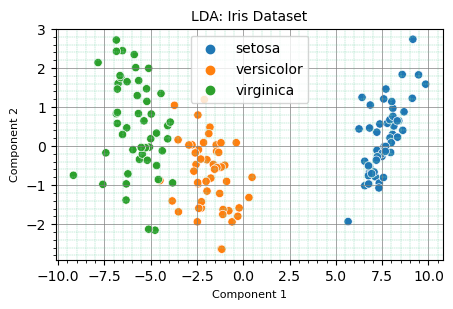

In [63]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=X_lda[:,0], y=X_lda[:,1], hue=iris.target_names[y])
plt.title("LDA: Iris Dataset", fontsize=10)
plt.xlabel("Component 1", fontsize=8)
plt.ylabel("Component 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()

### 6. Factor Analysis

- Identifies latent variables that explain the observed variables.
- Useful in psychometrics and social sciences.


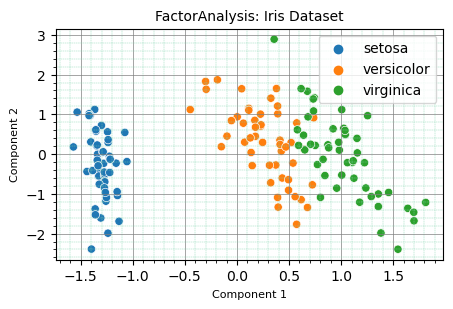

In [50]:
fa = FactorAnalysis(n_components=2)
X_fa = fa.fit_transform(X)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=X_fa[:,0], y=X_fa[:,1], hue=iris.target_names[y])
plt.title("FactorAnalysis: Iris Dataset", fontsize=10)
plt.xlabel("Component 1", fontsize=8)
plt.ylabel("Component 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()

### 7. Independent Component Analysis (ICA)

- Maximizes statistical independence of components.
- Useful for separating mixed signals (e.g., blind source separation).

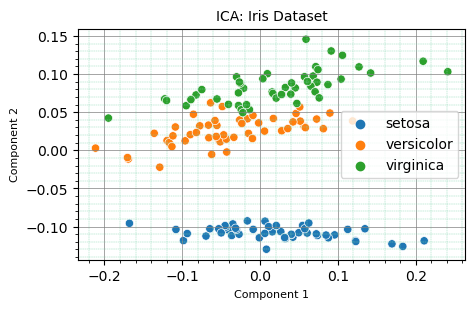

In [66]:
ica = FastICA(n_components=2, random_state=SEED)
X_ica = ica.fit_transform(X)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=X_ica[:,0], y=X_ica[:,1], hue=iris.target_names[y])
plt.title("ICA: Iris Dataset", fontsize=10)
plt.xlabel("Component 1", fontsize=8)
plt.ylabel("Component 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()

### 8. Locally Linear Embedding (LLE)
- Preserves local relationships in data using linear weights.
- Good for unfolding nonlinear manifolds.

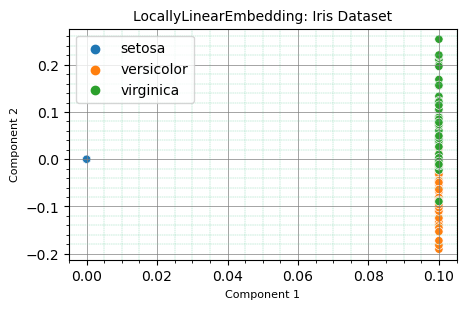

In [55]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_lle = lle.fit_transform(X)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=X_lle[:,0], y=X_lle[:,1], hue=iris.target_names[y])
plt.title("LocallyLinearEmbedding: Iris Dataset", fontsize=10)
plt.xlabel("Component 1", fontsize=8)
plt.ylabel("Component 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()

### 9. Isomap
- Combines PCA and manifold learning using geodesic distances.
- Preserves global geometric structure.

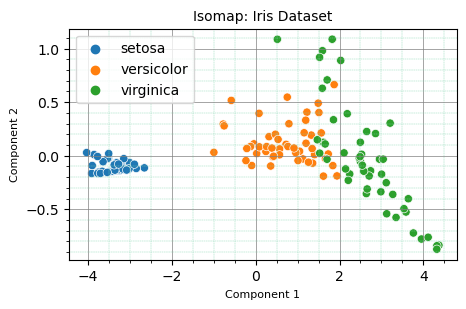

In [58]:
isomap = Isomap(n_components=2, n_neighbors=10)
X_isomap = isomap.fit_transform(X)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=X_isomap[:,0], y=X_isomap[:,1], hue=iris.target_names[y])
plt.title("Isomap: Iris Dataset", fontsize=10)
plt.xlabel("Component 1", fontsize=8)
plt.ylabel("Component 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()

| Goal                      | Suggested Methods                           |
|---------------------------|---------------------------------------------|
| Visualization (2D/3D)     | t-SNE, UMAP, PCA                            |
| Speed and scalability     | PCA, UMAP                                   |
| Preserving class info     | LDA, supervised autoencoders                |
| Handling nonlinearity     | t-SNE, UMAP, Isomap, Autoencoders           |
| Feature selection         | PCA, LDA, mutual information-based methods  |
